# Coauthor Dataset 
Description of the dataset ....

In [1]:
import os
import time
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import distanceclosure as dc
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx, from_networkx
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import remove_self_loops
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import torch_geometric.transforms as T
from torch_geometric.datasets import Coauthor
import torch_geometric.transforms.to_device
from src import add_weights_to_edges, mb_sparsify, generate_train_and_test_mask, GCN, train, test, eval_model, get_edge_idx_from_adj_matrix, get_num_edges_from_adj_matrix

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [4]:

transform_to_device = T.Compose([T.ToDevice(device)])
dataset = Coauthor(root='../data/Coauthor', name='CS', transform=T.NormalizeFeatures()) 
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
data = data

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!


Dataset: CoauthorCS():
Number of graphs: 1
Number of features: 6805
Number of classes: 15

Data(x=[18333, 6805], edge_index=[2, 163788], y=[18333])
Number of nodes: 18333
Number of edges: 163788
Average node degree: 8.93
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## Preprocessing the data
We separate the experiment into three categories of data
- The original graph
- The metric backbone of the graph with edges weighted by the inverse of their adamic-adar index
- The metric backbone of the graph with edges weighted by the inverse of their jaccard coefficient

In [5]:
from torch_geometric.transforms import RemoveDuplicatedEdges

G = to_networkx(data, to_undirected=True, node_attrs=data.node_attrs())
J = add_weights_to_edges(G, method='jaccard')
AA = add_weights_to_edges(G, method='adamic_adar')

#Using rust to compute the metric backbone
AA_mb = mb_sparsify(nx.to_numpy_array(AA))
J_mb = mb_sparsify(nx.to_numpy_array(J))

dataG = data.to(device)
data_AdamicAdar_mb = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(AA_mb), y=data.y).to(device)
data_Jaccard_mb = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(J_mb), y=data.y).to(device)

print(f'Original Graph : {dataG.num_edges/2} edges')
print(f'Metric Backbone of Adamic Adar weighted graph : {data_AdamicAdar_mb.num_edges/2} edges -> {data_AdamicAdar_mb.num_edges/dataG.num_edges*100:.2f}% of the edges remain')
print(f'Metric Backbone of Jaccard weighted graph : {data_Jaccard_mb.num_edges/2} edges -> {data_Jaccard_mb.num_edges/dataG.num_edges*100:.2f}% of the edges remain')

/var/folders/4l/t1p1zlw56kx34l_phf3ncrg40000gn/T/ipykernel_20163/228639859.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_AdamicAdar_mb = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(AA_mb), y=data.y).to(device)
/var/folders/4l/t1p1zlw56kx34l_phf3ncrg40000gn/T/ipykernel_20163/228639859.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_Jaccard_mb = Data(x = torch.tensor(dataG.x, dtype=torch.float32), edge_index=get_edge_idx_from_adj_matrix(J_mb), y=data.y).to(device)


Original Graph : 81894.0 edges
Metric Backbone of Adamic Adar weighted graph : 72948.0 edges -> 89.08% of the edges remain
Metric Backbone of Jaccard weighted graph : 71295.0 edges -> 87.06% of the edges remain


In [6]:
data_AdamicAdar_mb = transform_to_device(data_AdamicAdar_mb)
data_Jaccard_mb = transform_to_device(data_Jaccard_mb)  
dataG = transform_to_device(dataG)
train_mask, test_mask = generate_train_and_test_mask(data.num_nodes)
train_mask, test_mask = generate_train_and_test_mask(data.num_nodes)
num_features = data.num_features
num_classes = dataset.num_classes


## Evaluating the model on the full graph

Epoch: 001, Loss: 2.7074, Train: 0.2857, Test: 0.2861
Epoch: 010, Loss: 2.4406, Train: 0.2341, Test: 0.2328
Epoch: 020, Loss: 2.1272, Train: 0.2895, Test: 0.2882
Epoch: 030, Loss: 1.8577, Train: 0.4091, Test: 0.4055
Epoch: 040, Loss: 1.5901, Train: 0.5555, Test: 0.5569
Epoch: 050, Loss: 1.3520, Train: 0.6599, Test: 0.6636
Epoch: 060, Loss: 1.1243, Train: 0.7906, Test: 0.7843
Epoch: 070, Loss: 0.9378, Train: 0.8143, Test: 0.8075
Epoch: 080, Loss: 0.7935, Train: 0.8441, Test: 0.8336
Epoch: 090, Loss: 0.6793, Train: 0.8770, Test: 0.8720
Epoch: 100, Loss: 0.5907, Train: 0.8978, Test: 0.8893
Epoch: 110, Loss: 0.5288, Train: 0.9058, Test: 0.8979
Epoch: 120, Loss: 0.4620, Train: 0.9169, Test: 0.9083
Epoch: 130, Loss: 0.4295, Train: 0.9278, Test: 0.9183
Epoch: 140, Loss: 0.4057, Train: 0.9336, Test: 0.9213
Epoch: 150, Loss: 0.3749, Train: 0.9358, Test: 0.9244
Epoch: 160, Loss: 0.3505, Train: 0.9385, Test: 0.9258
Epoch: 170, Loss: 0.3333, Train: 0.9396, Test: 0.9270
Epoch: 180, Loss: 0.3211, Tr

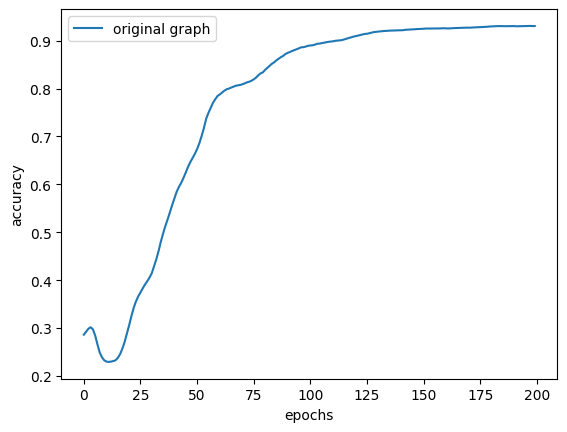

Median time per epoch: 0.05583310127258301s
Overall time: 16.72310495376587s
Best validation accuracy: 0.95


In [7]:
N_EPOCHS = 200

fg_model = GCN(num_features, 16, num_classes).to(device)
fg_criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
fg_optimizer = torch.optim.Adam(fg_model.parameters(), lr=0.01)  # Define optimizer.
fg_best_val_acc, fg_accs, fg_median_time_per_epoch, fg_overall_time = eval_model(fg_model, dataG, train_mask, test_mask, fg_optimizer,N_EPOCHS)
fig, ax = plt.subplots()

ax.plot(range(len(fg_accs)), fg_accs, label='original graph')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

print(f"Median time per epoch: {fg_median_time_per_epoch}s")
print(f"Overall time: {fg_overall_time}s")
print(f"Best validation accuracy: {fg_best_val_acc:.2f}")


## Evaluating the model on the metric backbone of the Adamic-Adar weighted graph

In [7]:
print(f"{dataG.x.shape}")

torch.Size([13752, 767])


Epoch: 001, Loss: 2.7079, Train: 0.1177, Test: 0.1072
Epoch: 010, Loss: 2.4655, Train: 0.1375, Test: 0.1269
Epoch: 020, Loss: 2.1639, Train: 0.3839, Test: 0.3780
Epoch: 030, Loss: 1.8740, Train: 0.4780, Test: 0.4782
Epoch: 040, Loss: 1.5732, Train: 0.5762, Test: 0.5769
Epoch: 050, Loss: 1.2951, Train: 0.7336, Test: 0.7322
Epoch: 060, Loss: 1.0629, Train: 0.8287, Test: 0.8230
Epoch: 070, Loss: 0.8877, Train: 0.8709, Test: 0.8656
Epoch: 080, Loss: 0.7443, Train: 0.8893, Test: 0.8848
Epoch: 090, Loss: 0.6469, Train: 0.9015, Test: 0.8953
Epoch: 100, Loss: 0.5696, Train: 0.9105, Test: 0.9027
Epoch: 110, Loss: 0.5043, Train: 0.9165, Test: 0.9096
Epoch: 120, Loss: 0.4757, Train: 0.9206, Test: 0.9129
Epoch: 130, Loss: 0.4336, Train: 0.9243, Test: 0.9157
Epoch: 140, Loss: 0.4092, Train: 0.9279, Test: 0.9182
Epoch: 150, Loss: 0.3871, Train: 0.9293, Test: 0.9198
Epoch: 160, Loss: 0.3652, Train: 0.9340, Test: 0.9239
Epoch: 170, Loss: 0.3476, Train: 0.9378, Test: 0.9270
Epoch: 180, Loss: 0.3416, Tr

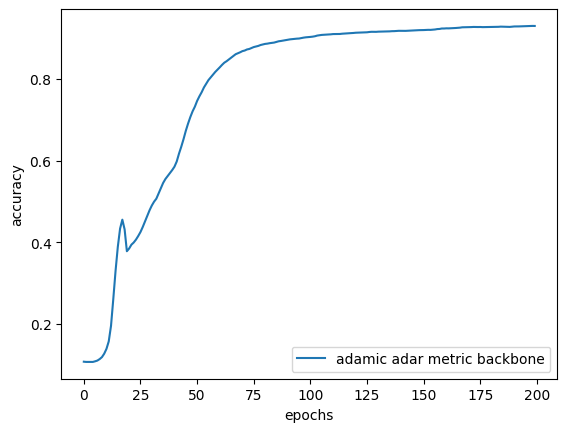

Median time per epoch: 0.05420207977294922s
Overall time: 11.076337814331055s
Best accuracy: 0.94%


In [8]:
aa_model = GCN(num_features, 16, num_classes).to(device)
aa_criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
aa_optimizer = torch.optim.Adam(aa_model.parameters(), lr=0.01)  # Define optimizer.
aa_best_val_acc, aa_accs, aa_median_time_per_epoch, aa_overall_time = eval_model(aa_model, data_AdamicAdar_mb, train_mask, test_mask, aa_optimizer, N_EPOCHS)
aa_fig, aa_ax = plt.subplots()

aa_ax.plot(range(len(aa_accs)), aa_accs, label='adamic adar metric backbone')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

print(f"Median time per epoch: {aa_median_time_per_epoch}s")
print(f"Overall time: {aa_overall_time}s")
print(f"Best accuracy: {aa_best_val_acc:.2f}%")

## Evaluating the model on the metric backbone of the Jaccard weighted graph

Epoch: 001, Loss: 2.7080, Train: 0.2375, Test: 0.2360
Epoch: 010, Loss: 2.4869, Train: 0.2686, Test: 0.2668
Epoch: 020, Loss: 2.1683, Train: 0.3666, Test: 0.3648
Epoch: 030, Loss: 1.8575, Train: 0.5079, Test: 0.5042
Epoch: 040, Loss: 1.5317, Train: 0.6441, Test: 0.6456
Epoch: 050, Loss: 1.2366, Train: 0.7686, Test: 0.7598
Epoch: 060, Loss: 1.0074, Train: 0.8254, Test: 0.8171
Epoch: 070, Loss: 0.8276, Train: 0.8535, Test: 0.8461
Epoch: 080, Loss: 0.7020, Train: 0.8702, Test: 0.8618
Epoch: 090, Loss: 0.6082, Train: 0.8862, Test: 0.8805
Epoch: 100, Loss: 0.5353, Train: 0.9077, Test: 0.9019
Epoch: 110, Loss: 0.4819, Train: 0.9211, Test: 0.9108
Epoch: 120, Loss: 0.4427, Train: 0.9253, Test: 0.9153
Epoch: 130, Loss: 0.4034, Train: 0.9306, Test: 0.9205
Epoch: 140, Loss: 0.3721, Train: 0.9358, Test: 0.9240
Epoch: 150, Loss: 0.3504, Train: 0.9388, Test: 0.9269
Epoch: 160, Loss: 0.3346, Train: 0.9413, Test: 0.9284
Epoch: 170, Loss: 0.3129, Train: 0.9429, Test: 0.9292
Epoch: 180, Loss: 0.3004, Tr

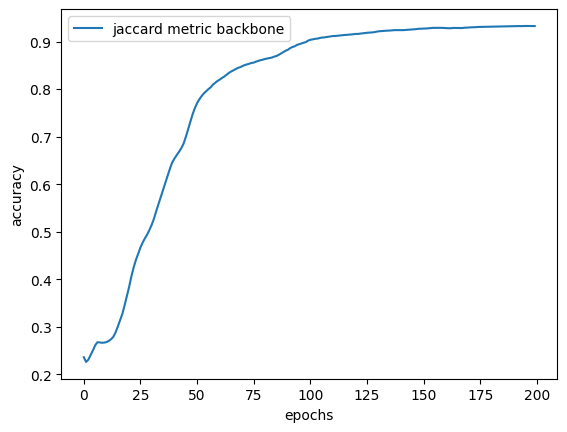

Median time per epoch: 0.052475690841674805s
Overall time: 10.718906879425049s
Best accuracy: 0.95%


In [9]:
j_model = GCN(num_features, 16, num_classes).to(device)
j_criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
j_optimizer = torch.optim.Adam(j_model.parameters(), lr=0.01)  # Define optimizer.
j_best_val_acc, j_accs, j_median_time_per_epoch, j_overall_time = eval_model(j_model, data_Jaccard_mb, train_mask, test_mask, j_optimizer, N_EPOCHS)
j_fig, j_ax = plt.subplots()

j_ax.plot(range(len(j_accs)), j_accs, label='jaccard metric backbone')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

print(f"Median time per epoch: {j_median_time_per_epoch}s")
print(f"Overall time: {j_overall_time}s")
print(f"Best accuracy: {j_best_val_acc:.2f}%")

## Plots

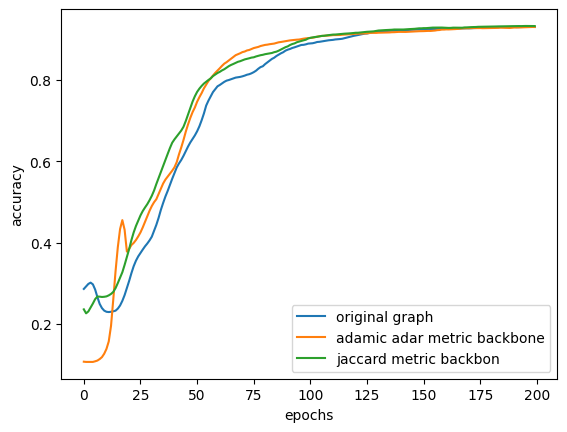

In [10]:
fig, ax = plt.subplots()
ax.plot(range(len(fg_accs)), fg_accs, label='original graph')
ax.plot(range(len(fg_accs)), aa_accs, label='adamic adar metric backbone')
ax.plot(range(len(fg_accs)), j_accs, label='jaccard metric backbon')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()
